# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

import sklearn

import os
import math

%matplotlib inline


# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "/Users/juntao/ML_Fall_2021-master/assignments/bankruptcy_one_yr"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

In [5]:
df_object_cols = data.select_dtypes(include='object').columns.tolist()
for ele in df_object_cols:
    data[ele] = pd.to_numeric(data[ele],errors='coerce' )

In [6]:
data.describe()
data["Bankrupt"].value_counts() 
#4510 not bankrupt, 308 went bankrupt.Our data is highly imbalanced, I will use SMOTE techniques to solve this issue

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
count,4816.000000,4816.000000,4816.000000,4803.000000,4.808000e+03,4816.000000,4816.000000,4804.000000,4818.000000,4816.000000,...,4816.000000,4818.000000,4816.000000,4.598000e+03,4806.000000,4818.000000,4803.000000,4735.000000,4818.000000,4818.000000
mean,-0.055232,0.533272,0.188992,4.978602,1.956441e+01,-0.070060,-0.042516,5.739985,1.579277,0.503606,...,0.022793,0.959585,0.273025,1.108795e+03,11.021303,177.494445,9.287631,38.557533,0.063927,3499.858032
std,6.707351,1.202909,1.282430,100.273952,2.384491e+04,7.778523,6.707970,109.508001,1.342723,4.044036,...,7.249022,0.932427,6.338601,7.106563e+04,43.821146,2279.713700,113.225922,588.711967,0.244648,1392.049260
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000,1071.000000
25%,0.004047,0.254670,0.044923,1.099200,-4.312000e+01,0.000000,0.005985,0.481588,1.015600,0.318990,...,0.015574,0.876940,0.000000,5.298300e+00,4.229925,45.065750,3.074350,2.114850,0.000000,2296.250000
50%,0.046487,0.451495,0.218560,1.642300,3.673450e-01,0.000000,0.056685,1.149000,1.140500,0.522325,...,0.108940,0.950825,0.006320,9.038900e+00,6.176800,73.879500,4.928700,4.077200,0.000000,3500.500000
75%,0.116730,0.662178,0.420153,2.929200,4.986775e+01,0.110470,0.136025,2.781300,1.814050,0.721823,...,0.240262,0.990358,0.206915,1.720750e+01,9.302800,118.597500,8.067850,9.187600,0.000000,4704.750000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000,1.000000,5909.000000


0    4510
1     308
Name: Bankrupt, dtype: int64

In [7]:
#Exploratory Data Analysis
#Visualization

In [8]:
data= data.drop(['Id'], axis = 1)#id is irrelevant to bankruptcy

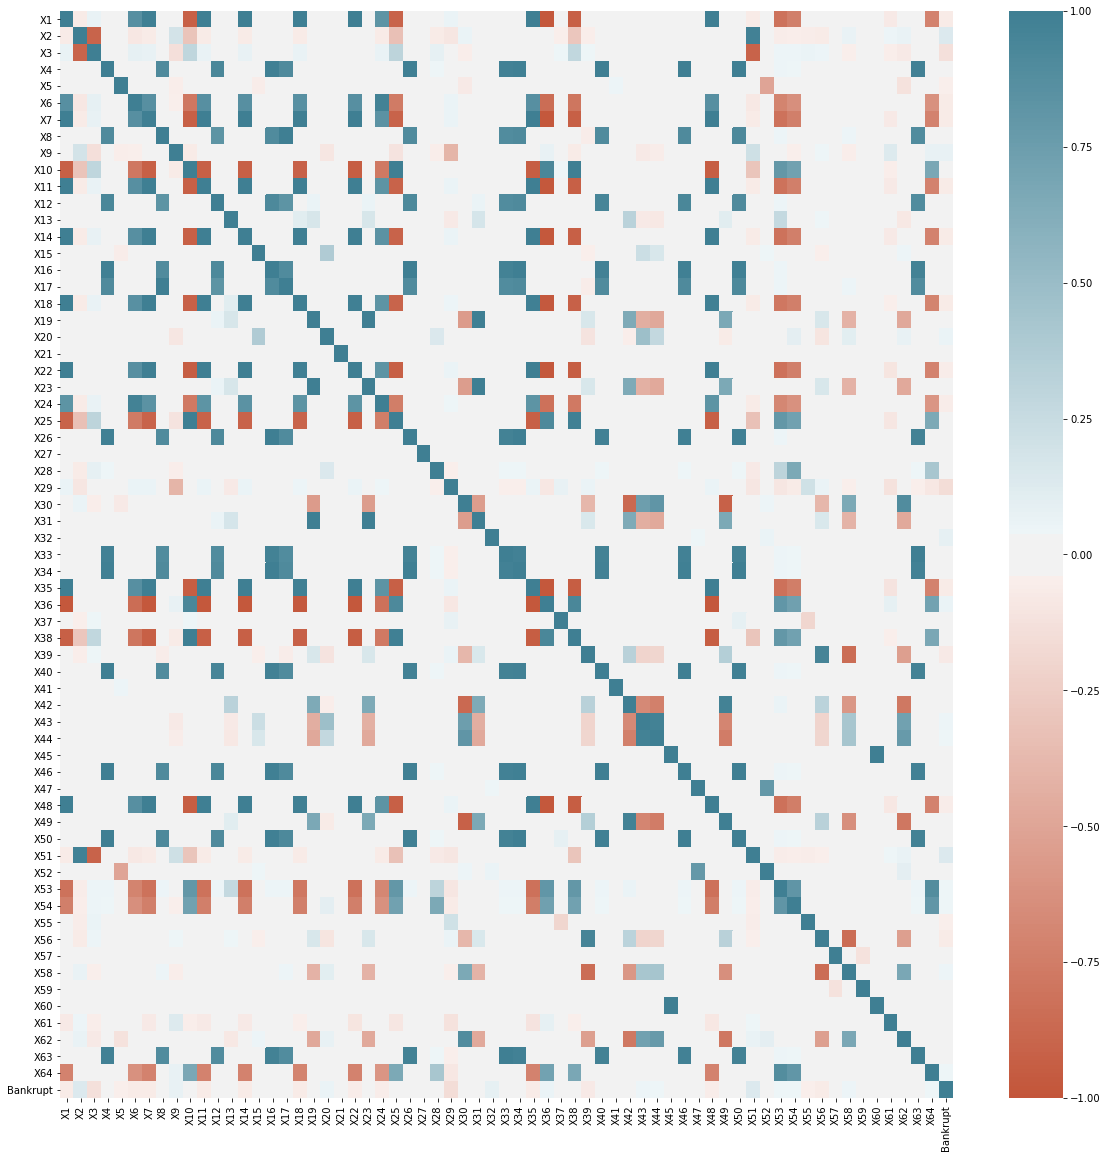

In [9]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), annot=False)

In [10]:
#take a look at some highly correlated indicators
corr = data.corr() 
c1 = corr.unstack()
c1.sort_values(ascending = False)[60:100]

X28  X28    1.000000
X29  X29    1.000000
X63  X63    1.000000
X33  X33    1.000000
X1   X1     1.000000
X14  X7     1.000000
X7   X14    1.000000
     X1     0.999983
X1   X7     0.999983
X14  X1     0.999982
X1   X14    0.999982
X8   X17    0.999977
X17  X8     0.999977
X26  X16    0.999972
X16  X26    0.999972
X7   X11    0.999969
X11  X7     0.999969
X14  X11    0.999969
X11  X14    0.999969
X1   X11    0.999953
X11  X1     0.999953
X23  X19    0.999925
X19  X23    0.999925
X60  X45    0.999904
X45  X60    0.999904
X22  X35    0.999832
X35  X22    0.999832
X46  X4     0.999778
X4   X46    0.999778
X31  X19    0.999575
X19  X31    0.999575
X31  X23    0.999481
X23  X31    0.999481
X63  X33    0.999350
X33  X63    0.999350
X22  X48    0.999317
X48  X22    0.999317
X35  X48    0.999221
X48  X35    0.999221
X38  X10    0.998118
dtype: float64

In [11]:
#Also, take a look at the missing values！
for col in data:
    if data[col].isna().sum()>0:
        print(col,data[col].isna().sum())
#in particular, X37 (current assets - inventories) / long-term liabilities has more than 2000 missing values a lot! It is useless, I am going to drop it!

X1 2
X2 2
X3 2
X4 15
X5 10
X6 2
X7 2
X8 14
X10 2
X11 2
X12 15
X14 2
X15 6
X16 14
X17 14
X18 2
X21 74
X22 2
X24 116
X25 2
X26 14
X27 305
X28 83
X29 2
X32 42
X33 15
X34 14
X35 2
X36 2
X37 2068
X38 2
X40 15
X41 62
X45 220
X46 15
X47 31
X48 2
X50 14
X51 2
X52 32
X53 83
X54 83
X57 2
X59 2
X60 220
X61 12
X63 15
X64 83


In [12]:
#Some attributes are highly correlated with one another, so we will drop them. 
data = data.drop(["X7", 'X11', "X14", "X17", "X18", "X22","X23", "X25","X26","X31","X34","X35", "X37","X38","X40",'X46',"X48", "X50","X60", "X63"], axis = 1)
#Since there are lots of outliers and skewness, I am going to fill na with median
#data = data.fillna(data.median())

<Figure size 1440x1440 with 0 Axes>

Text(0.5, 1.0, 'Data Boxplots')

[None]

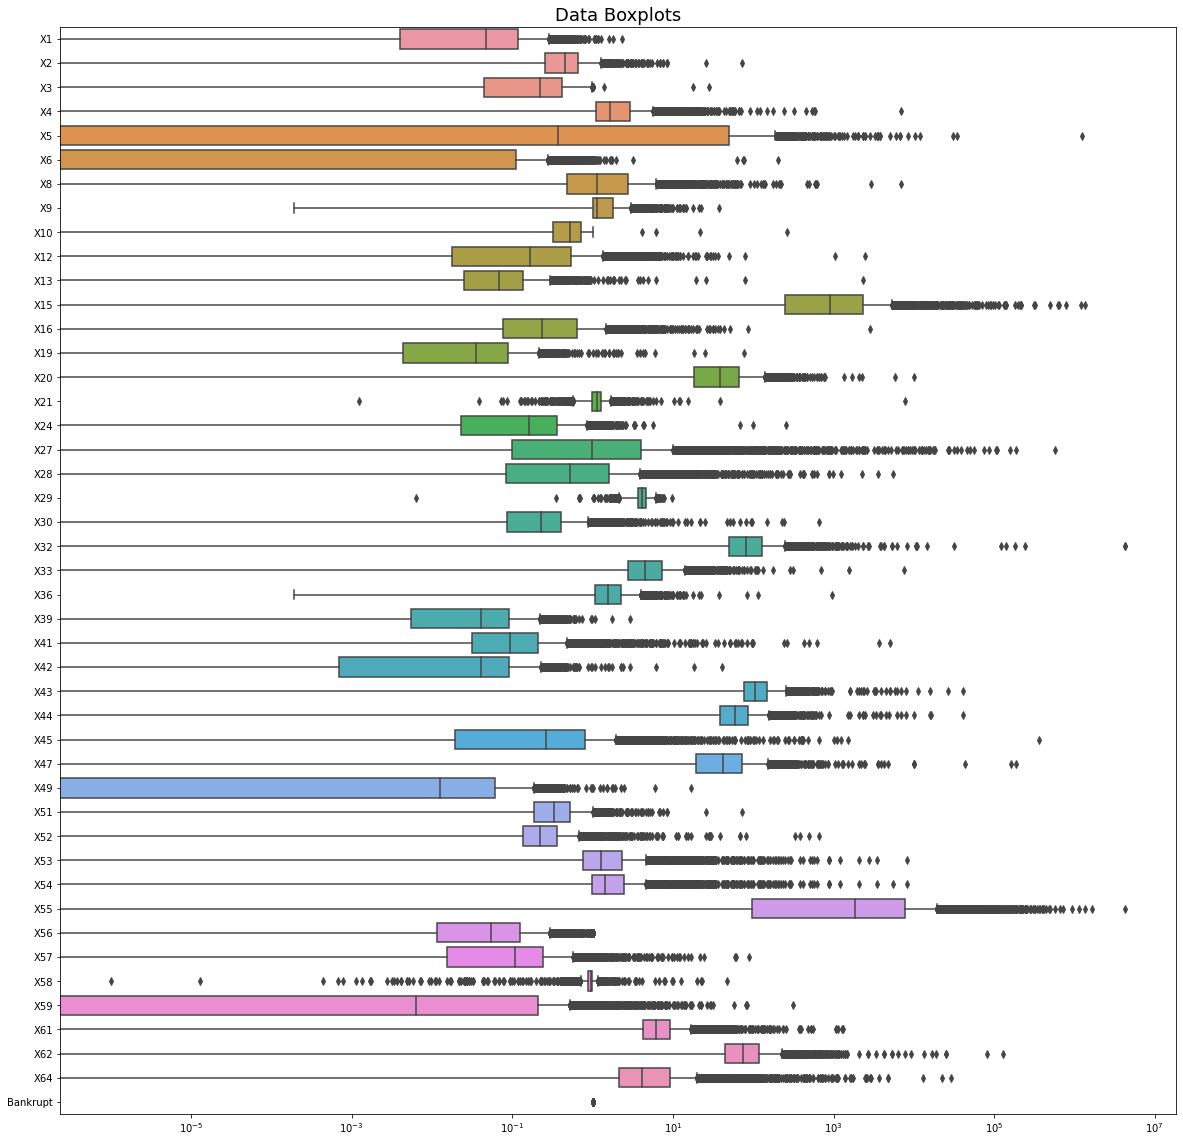

In [13]:
#Lets take a look at the box plot
plt.figure(figsize = (20,20))
ax =sns.boxplot(data = data, orient="h")
ax.set_title('Data Boxplots', fontsize = 18)
ax.set(xscale="log")
#lots of outliers and skewness!Unacceptable!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaf3cc4ca0>,
      dtype=object)

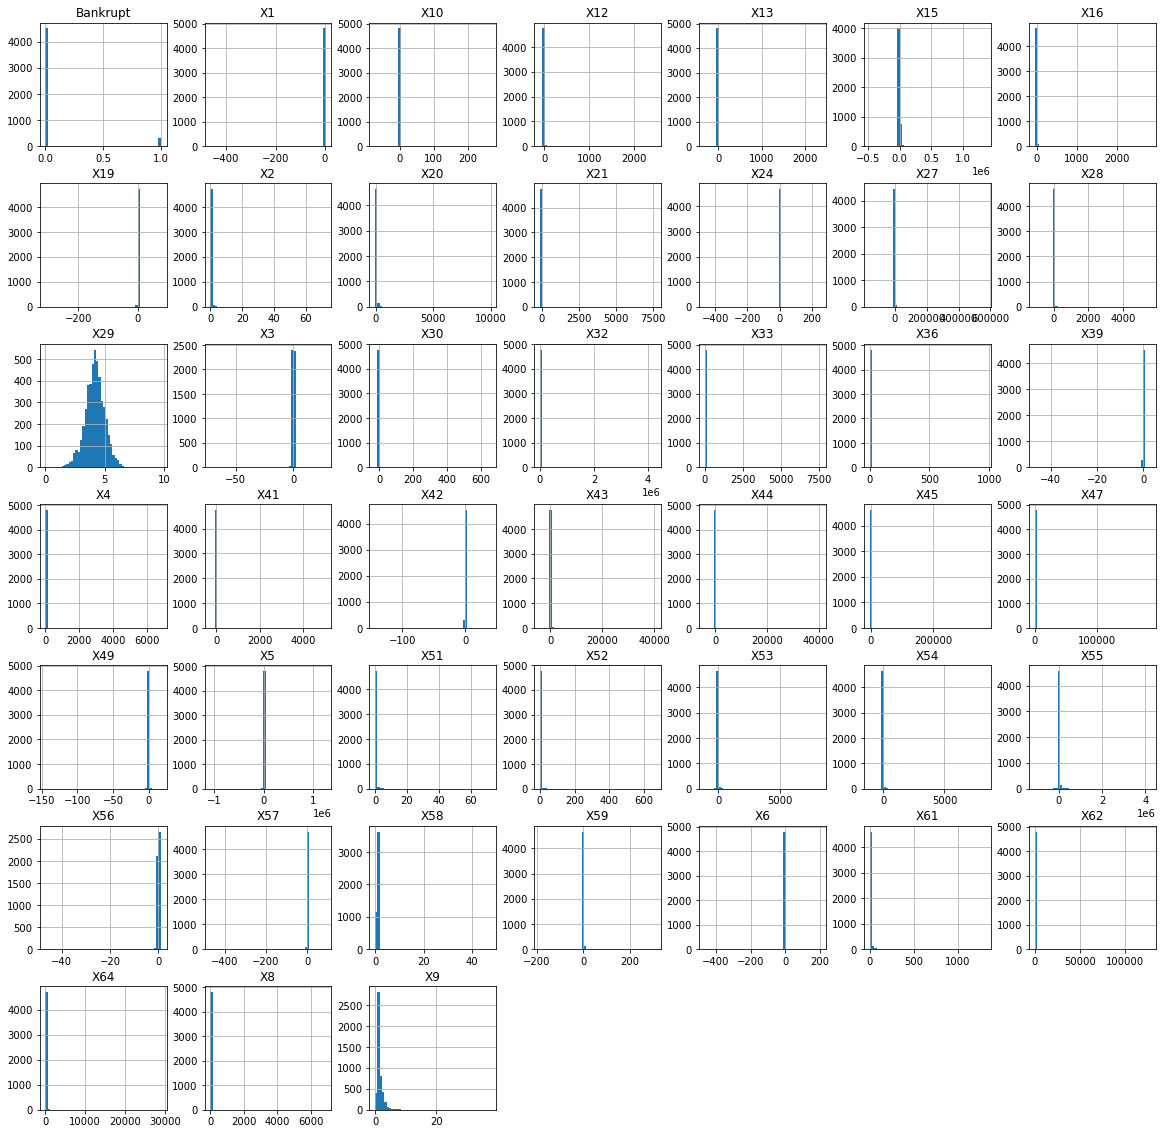

In [14]:
data.hist(figsize = (20,20),bins = 50)
#messy data with different scales, not normal distributions, not zero mean

In [15]:
y = data['Bankrupt']
X = data.drop(['Bankrupt'], axis = 1)

In [16]:
from sklearn.model_selection import train_test_split

X_train = None
X_test = None
y_train = None
y_test = None

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size = 0.8, random_state=42)

In [17]:
colmns=[]
for col in X_train:
    colmns.append(col)
#store the list of columns

In [18]:
from sklearn.impute import SimpleImputer
#filling missing values by median
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(X_train)
X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

SimpleImputer(strategy='median')

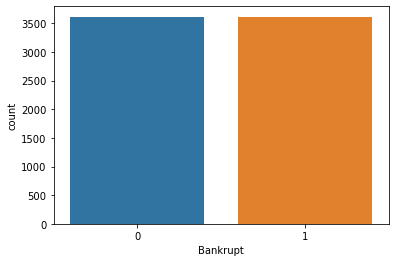

In [19]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train,y_train=oversample.fit_resample(X_train,y_train)
sns.countplot(x=y_train)
#handling imbalanced data

In [20]:
#let's do standardization! I need to do standardization because I want to use PCA later. PCA requires zero mean. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

StandardScaler()

In [21]:
#convert X_train, X_test to dataframe because it would be easier for us to visualize
X_train = pd.DataFrame(X_train_s, columns = colmns)
X_test = pd.DataFrame(X_test_s, columns = colmns)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaf69a83d0>,
      dtype=object)

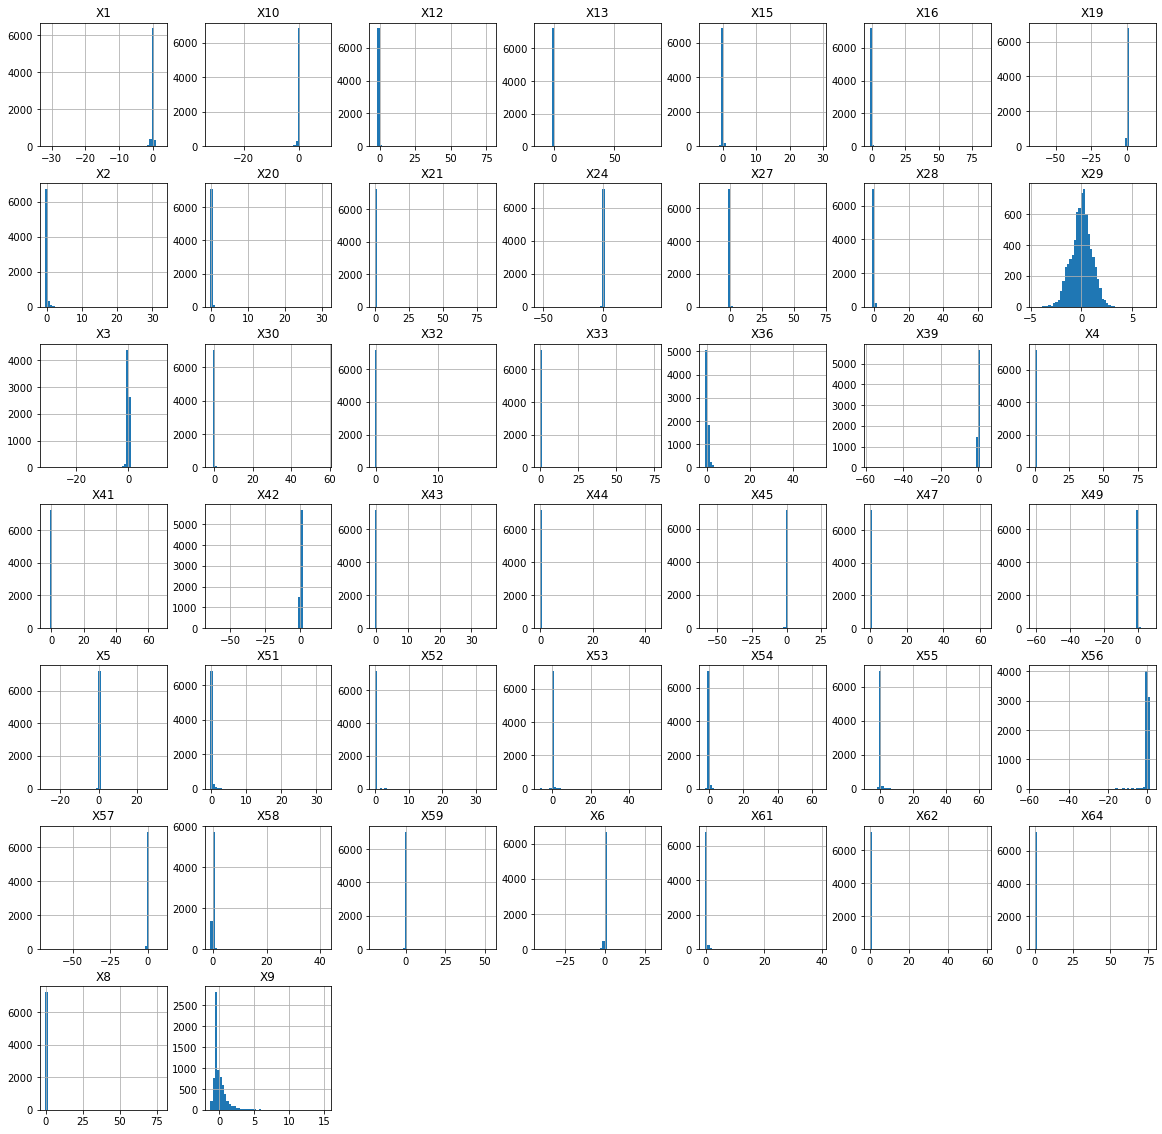

In [22]:
X_train.hist(figsize = (20,20),bins = 50)
#slightly better, but still lots of outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feaf58108e0>,
      dtype=object)

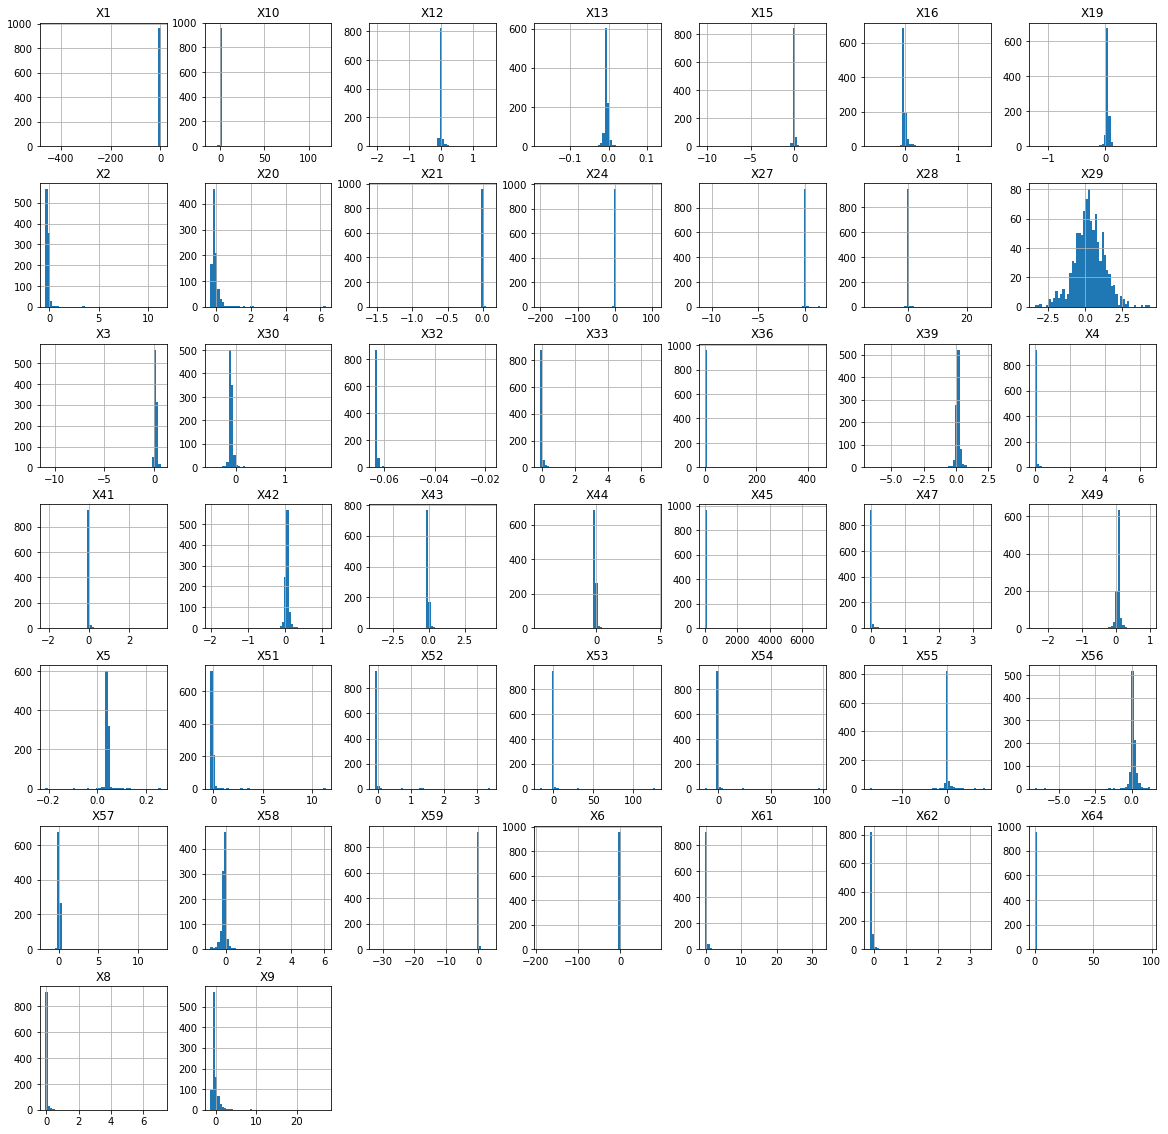

In [23]:
X_test.hist(figsize = (20,20),bins = 50)

In [24]:
#I can still see lots out outliers in X_train and X_split. This will affect my PCA. Lets try replacing outliers by min and max
def identify(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    median = series.median()
    IQR = q3-q1
    
    upper_bound = q3+1.5*IQR
    lower_bound = q1-1.5*IQR
    return [lower_bound, upper_bound]

def outlier_replace(df,a):
    low = a[0]
    high = a[1]
    
    for i in range(0,len(df)):
        if df[i] < low:       
            df[i] = low
        if df[i] > high: 
            df[i] = high
    return df
keep = {}
for col in X_train:
    lh = identify(X_train[col])
    X_train[col] = outlier_replace(X_train[col],lh)
    X_test[col] = outlier_replace(X_test[col],lh)
    keep[col] = lh

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feadf44a160>,
      dtype=object)

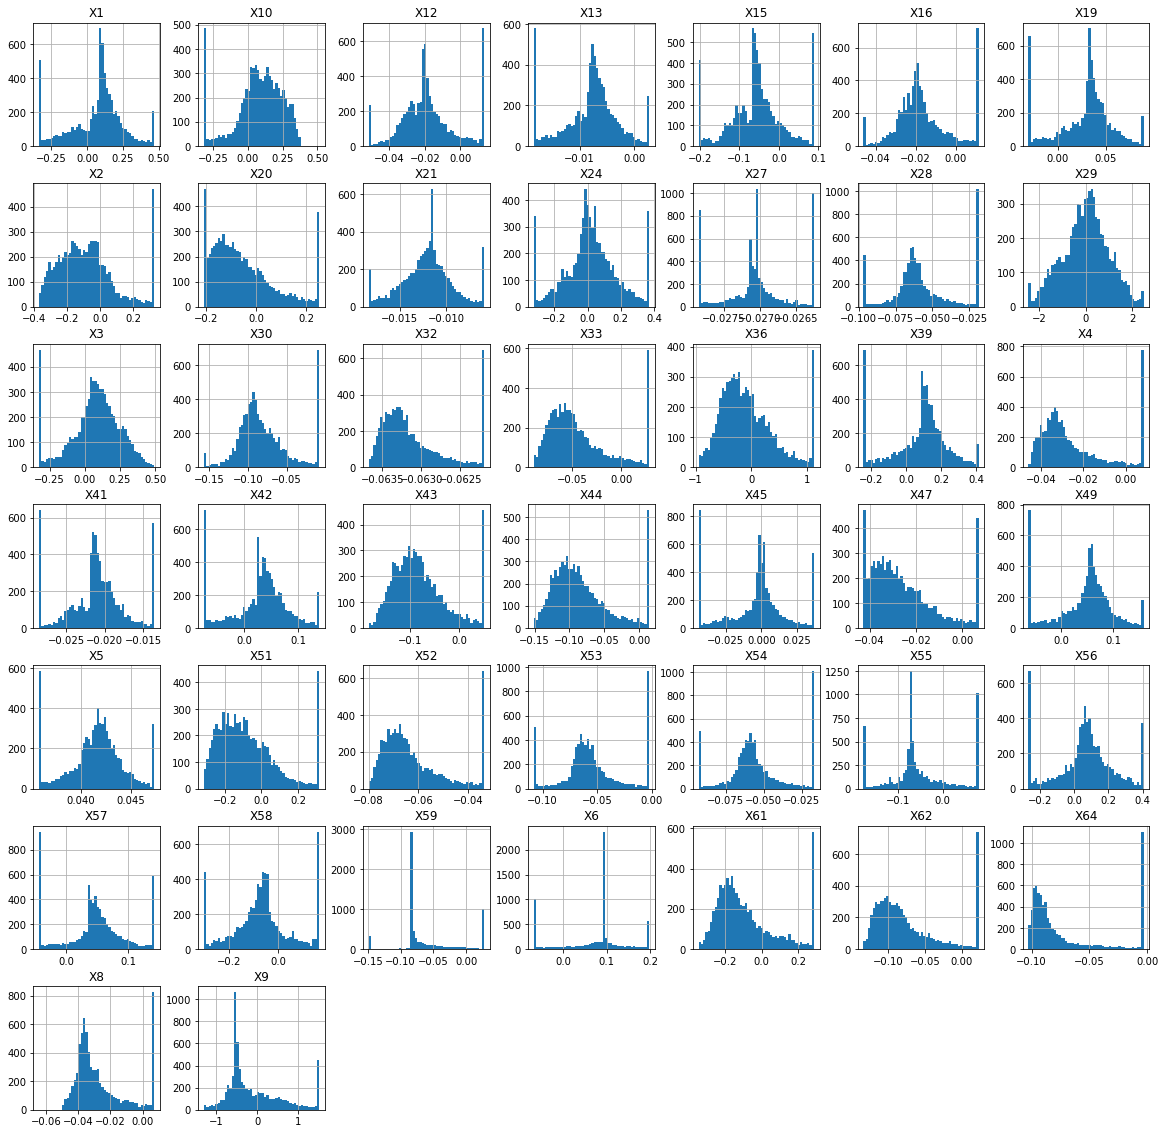

In [25]:
X_train.hist(figsize = (20,20),bins = 50)
#much better!

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feae289cc40>,
      dtype=object)

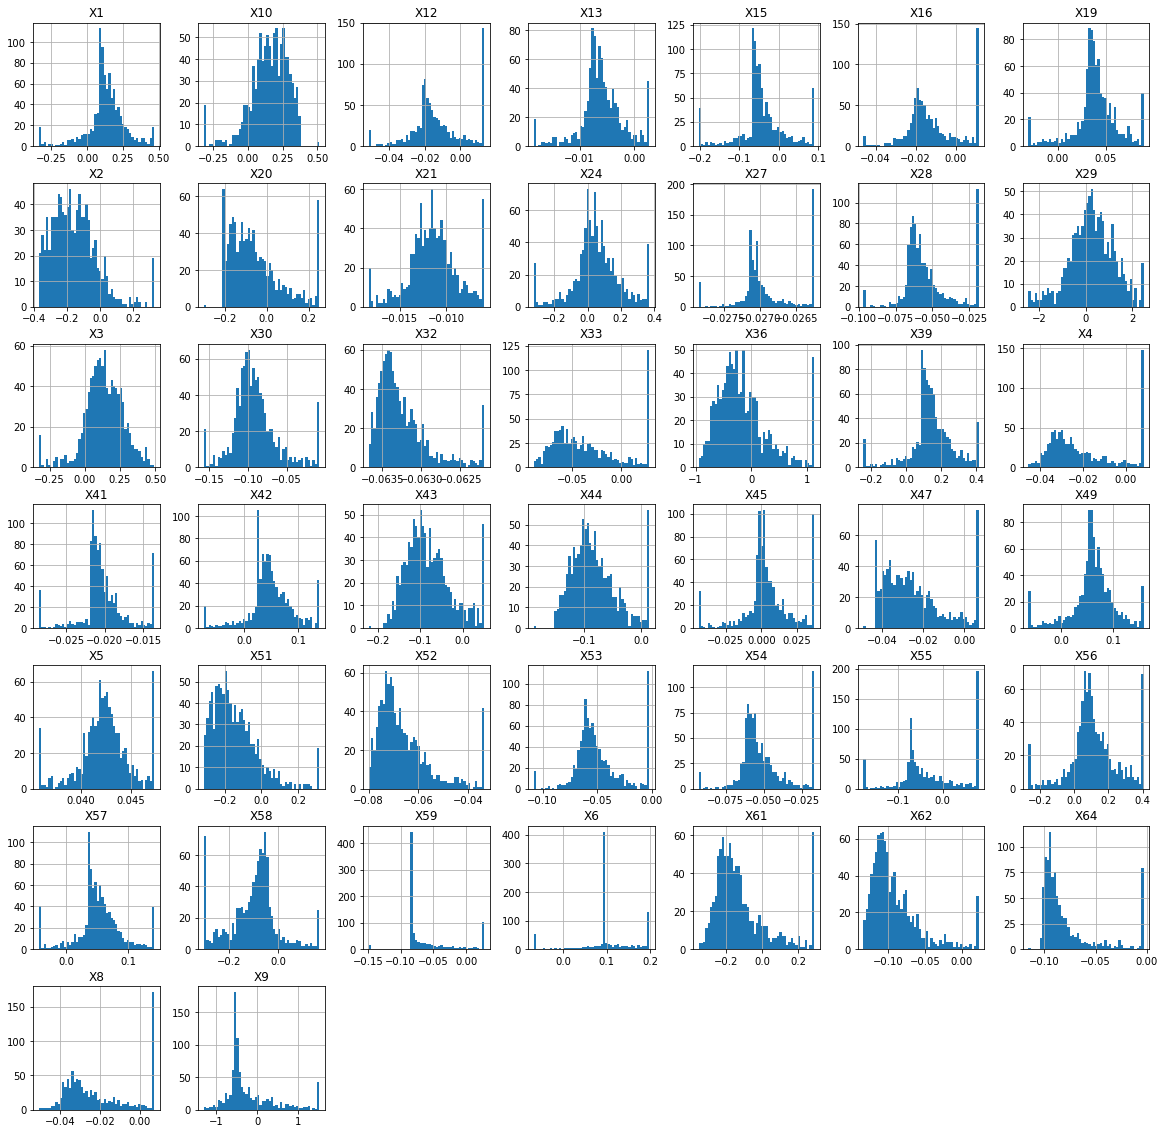

In [26]:
#My histogram looks better now. I can see the bell shape in my histogram
X_test.hist(figsize = (20,20),bins = 50)

In [27]:
from sklearn.decomposition import PCA

In [28]:
def Pca(data, n_components):
    if n_components is not None:
        pca = PCA(n_components=n_components)
    else:
        pca = PCA()
    pca.fit(data)

    return pca

def transform(X,  model):
    X_transformed = model.transform(X)
    return X_transformed

def num_components_for_cum_variance(pca, thresh):
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(cumsum >= thresh) + 1
    return d

def plot_cum_variance(pca):
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    x  = range(1, 1 + cumsum.shape[0])
        
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    _ = ax.plot(x, cumsum)

    _ = ax.set_title("Cumulative variance explained")
    _ = ax.set_xlabel("# of components")
    _ = ax.set_ylabel("Fraction total variance")

    _= ax.set_yticks( np.linspace(0,1,11)  )

    return fig, ax


In [29]:
pca = Pca(X_train,0.99)
pca.n_components_
X_train_reduced = transform(X_train, pca)
X_train_reduced.shape

12

(7232, 12)

To capture 99% of variance we need 12 synthetic features.


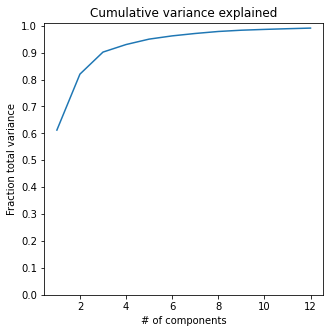

In [30]:
_ = plot_cum_variance(pca)

variance_goal_pct = 99
features_for_goal = num_components_for_cum_variance(pca, .01 * variance_goal_pct)
print("To capture {f:d}% of variance we need {d:d} synthetic features.".format(f=variance_goal_pct, d=features_for_goal))


In [31]:
X_test_reduced = transform(X_test, pca)
X_test_reduced.shape


X_train_df = pd.DataFrame(X_train_reduced, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E','Column_F','Column_G','Column_H','Column_I','Column_J','Column_K','Column_L'])
X_test_df = pd.DataFrame(X_test_reduced, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E', 'Column_F','Column_G','Column_H','Column_I','Column_J','Column_K','Column_L'])



(964, 12)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
#First lets try logisticRegression model, find the best parameters using randomized search 
lr = LogisticRegression()

lr_pipeline = Pipeline(steps = [('classify',lr)])
param_grid = {
    'classify__penalty': ['l1','l2'],
    'classify__C': [0.1,1,3,5],
    'classify__class_weight': ['balanced',None],
    'classify__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

rand_cv_model = RandomizedSearchCV(lr_pipeline, param_grid , n_iter= 10)
rand_cv_model.fit(X_train_df, y_train)


print("Best parameter (CV score=%0.3f):" % rand_cv_model.best_score_)
print(rand_cv_model.best_params_)

/Users/juntao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/juntao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/juntao/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/juntao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/juntao/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
Valu

/Users/juntao/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.7789005         nan 0.7789004  0.78014502        nan 0.7789005
 0.7789004  0.7789005  0.77876209 0.77973037]
  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('classify',
                                              LogisticRegression())]),
                   param_distributions={'classify__C': [0.1, 1, 3, 5],
                                        'classify__class_weight': ['balanced',
                                                                   None],
                                        'classify__penalty': ['l1', 'l2'],
                                        'classify__solver': ['newton-cg',
                                                             'lbfgs',
                                                             'liblinear', 'sag',
                                                             'saga']})

Best parameter (CV score=0.780):
{'classify__solver': 'newton-cg', 'classify__penalty': 'l2', 'classify__class_weight': None, 'classify__C': 1}


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

lr_tuned= LogisticRegression(solver="liblinear",C=1,penalty = 'l2',class_weight = 'balanced',)
name = "Logistic_Regression_classifier"

lr_tuned.fit(X_train_df, y_train)
lr_predict=lr_tuned.predict(X_test_df)

accuracy = accuracy_score(y_test, lr_predict)
# recall
recall = recall_score(y_test, lr_predict, pos_label=1, average="binary")

# precision
precision = precision_score(y_test, lr_predict, pos_label=1, average="binary")


print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy,
                                                                            r=recall,
                                                                            p=precision
                                                                            ))

LogisticRegression(C=1, class_weight='balanced', solver='liblinear')

	Logistic_Regression_classifier Accuracy: 80.5%, Recall 72.9%, Precision 23.2%


In [34]:
from sklearn.svm import SVC

svc = SVC()
svc_pipeline = Pipeline(steps = [('classify',svc)])
param_grid = {
    'classify__kernel': ['rbf', 'poly','sigmoid'],
    'classify__C': [0.01,0.1,1,2],
    'classify__gamma':['scale','auto'],
    #'classify__degree':[2,3,4]
}

rand_cv_model = RandomizedSearchCV(svc_pipeline, param_grid , n_iter= 10)
rand_cv_model.fit(X_train_df, y_train)


print("Best parameter (CV score=%0.3f):" % rand_cv_model.best_score_)
print(rand_cv_model.best_params_)


RandomizedSearchCV(estimator=Pipeline(steps=[('classify', SVC())]),
                   param_distributions={'classify__C': [0.01, 0.1, 1, 2],
                                        'classify__gamma': ['scale', 'auto'],
                                        'classify__kernel': ['rbf', 'poly',
                                                             'sigmoid']})

Best parameter (CV score=0.780):
{'classify__kernel': 'rbf', 'classify__gamma': 'auto', 'classify__C': 0.1}


In [35]:
svc_tuned = SVC(C=2, kernel = 'rbf', gamma = 'scale')
name = 'SVC'
svc_tuned.fit(X_train_df, y_train)
svc_predict=svc_tuned.predict(X_test_df)

accuracy = accuracy_score(y_test, svc_predict)
# recall
recall = recall_score(y_test, svc_predict, pos_label=1, average="binary")

# precision
precision = precision_score(y_test, svc_predict, pos_label=1, average="binary")


print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy,
                                                                            r=recall,
                                                                            p=precision
                                                                            ))

SVC(C=2)

	SVC Accuracy: 84.9%, Recall 58.6%, Precision 25.9%


In [36]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
name = "Decision Tree Classifier"

dtc_pipeline = Pipeline(steps = [('classify',dtc)])
param_grid = {
    'classify__splitter': ['best','random'],
    'classify__max_depth': [20,25,30],
    'classify__min_samples_split':[2,4,6],
}

rand_cv_model = RandomizedSearchCV(dtc_pipeline, param_grid , n_iter= 10)
rand_cv_model.fit(X_train_df, y_train)


print("Best parameter (CV score=%0.3f):" % rand_cv_model.best_score_)
print(rand_cv_model.best_params_)


RandomizedSearchCV(estimator=Pipeline(steps=[('classify',
                                              DecisionTreeClassifier())]),
                   param_distributions={'classify__max_depth': [20, 25, 30],
                                        'classify__min_samples_split': [2, 4,
                                                                        6],
                                        'classify__splitter': ['best',
                                                               'random']})

Best parameter (CV score=0.872):
{'classify__splitter': 'best', 'classify__min_samples_split': 4, 'classify__max_depth': 30}


In [37]:
dtc_tuned = DecisionTreeClassifier(splitter = 'random', min_samples_split=2, max_depth=30)
dtc_tuned.fit(X_train_df, y_train)
dtc_tuned_predict = dtc_tuned.predict(X_test_df)

accuracy = accuracy_score(y_test, dtc_tuned_predict)
# recall
recall = recall_score(y_test, dtc_tuned_predict, pos_label=1, average="binary")

# precision
precision = precision_score(y_test,dtc_tuned_predict, pos_label=1, average="binary")


print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy,
                                                                            r=recall,
                                                                            p=precision
                                                                            ))

DecisionTreeClassifier(max_depth=30, splitter='random')

	Decision Tree Classifier Accuracy: 81.2%, Recall 40.0%, Precision 16.8%


In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
name = "Random_Forest_classifier"

rfc_pipeline = Pipeline(steps = [('classify',rfc)])
param_grid = {
    'classify__n_estimators': [100,150,200],
    'classify__max_depth': [20,25,30],
    'classify__max_features':['auto', 'sqrt', 'log2'],
    'classify__class_weight':['balanced','balanced_subsample'],
    'classify__criterion':['gini', 'entropy'],
}

rand_cv_model = RandomizedSearchCV(rfc_pipeline, param_grid , n_iter= 10)
rand_cv_model.fit(X_train_df, y_train)


print("Best parameter (CV score=%0.3f):" % rand_cv_model.best_score_)
print(rand_cv_model.best_params_)



RandomizedSearchCV(estimator=Pipeline(steps=[('classify',
                                              RandomForestClassifier())]),
                   param_distributions={'classify__class_weight': ['balanced',
                                                                   'balanced_subsample'],
                                        'classify__criterion': ['gini',
                                                                'entropy'],
                                        'classify__max_depth': [20, 25, 30],
                                        'classify__max_features': ['auto',
                                                                   'sqrt',
                                                                   'log2'],
                                        'classify__n_estimators': [100, 150,
                                                                   200]})

Best parameter (CV score=0.942):
{'classify__n_estimators': 200, 'classify__max_features': 'log2', 'classify__max_depth': 20, 'classify__criterion': 'gini', 'classify__class_weight': 'balanced_subsample'}


In [39]:
rfc_tuned = RandomForestClassifier(n_estimators = 150,max_depth=25,max_features = 'log2', criterion = 'gini', class_weight = 'balanced_subsample')
rfc_tuned.fit(X_train_df, y_train)
rfc_tuned_predict=rfc_tuned.predict(X_test_df)

accuracy = accuracy_score(y_test, rfc_tuned_predict)
# recall
recall = recall_score(y_test, rfc_tuned_predict, pos_label=1, average="binary")

# precision
precision = precision_score(y_test, rfc_tuned_predict, pos_label=1, average="binary")


print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy,
                                                                            r=recall,
                                                                            p=precision
                                                                            ))

RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                       max_features='log2', n_estimators=150)

	Random_Forest_classifier Accuracy: 90.7%, Recall 50.0%, Precision 38.9%


# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [40]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)

Data shape:  (1092, 65)


In [41]:
df_object_cols = holdout_data.select_dtypes(include='object').columns.tolist()
for ele in df_object_cols:
    holdout_data[ele] = pd.to_numeric(holdout_data[ele],errors='coerce' )

In [42]:
holdout_data = holdout_data.drop(['Id'],axis = 1)

We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

In [43]:
holdout_data = holdout_data.drop(["X7", 'X11', "X14", "X17", "X18", "X22","X23", "X25","X26","X31","X34","X35", "X37","X38","X40",'X46',"X48", "X50","X60", "X63"], axis = 1)

In [44]:
holdout_data = imp_mean.transform(holdout_data)

In [45]:
holdout_data_s = scaler.transform(holdout_data)

In [46]:
holdout_data = pd.DataFrame(holdout_data_s, columns = colmns)

In [47]:
for key, value in keep.items():
    holdout_data[key] = outlier_replace(holdout_data[key],value)

In [48]:
holdout_data_reduced = transform(holdout_data, pca)
holdout_data_reduced.shape

X_hold = pd.DataFrame(holdout_data_reduced, columns = ['Column_A','Column_B','Column_C','Column_D','Column_E', 'Column_F','Column_G','Column_H','Column_I','Column_J','Column_K','Column_L'])

(1092, 12)

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

In [49]:
import pandas as pd
import os
#I choose logistic regression model simply because it has the highest recall score. In fact, its recall score is much much higher than the recall score of other models. 
#There are two reasons why I choose logistic regression. 1. high recall score is desirable in this project as mentioned by the instructor 2. high accuracy score is not as crucial as recall score. For example, since my raw data is highly imbalanced, simply predicting all the companies to be 0 will give a high accuracy score. Thus, high recall score is more meaningful 
def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions=lr_tuned.predict(X)
    return predictions

y_hold_pred = MyModel(X_hold)
print(len(y_hold_pred))
print(sum(y_hold_pred))

1092
261


# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [50]:
name = "My Logistic Regression model"
y_test_pred = MyModel(X_test_df)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )
print(sum(y_test_pred))
print(len(y_test_pred))

	My Logistic Regression model Accuracy: 80.5%, Recall 72.9%, Precision 23.2%
220
964
